In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe_open
import bmi_cfe_enkf_peturb
#import bmi_cfe_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI

#sys.path.append('/home/jovyan/data/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT')
sys.path.append('../USGS/USGS_BMI_FT')
import bmi_usgs

#new bmi_cfe is CFE open and cfe peturb

In [2]:
print(bmi_cfe_open)
#print(bmi_cfe_peturb)
print(bmi_cfe_enkf_peturb)
print(Bmi_da_ENKF_forSBMI)
print(bmi_usgs)


<module 'bmi_cfe_open' from '/home/jovyan/data/project/Draft/final/NextGen---The-Simulators-/Toy_Model/./CFE/bmi_cfe_open.py'>
<module 'bmi_cfe_enkf_peturb' from '/home/jovyan/data/project/Draft/final/NextGen---The-Simulators-/Toy_Model/./CFE/bmi_cfe_enkf_peturb.py'>
<module 'Bmi_da_ENKF_forSBMI' from '/home/jovyan/data/project/Draft/final/NextGen---The-Simulators-/Toy_Model/./Assimilation/Bmi_da_ENKF_forSBMI.py'>
<module 'bmi_usgs' from '/home/jovyan/data/project/Draft/final/NextGen---The-Simulators-/Toy_Model/../USGS/USGS_BMI_FT/bmi_usgs.py'>


In [3]:
## Open BMI's for each file
# cfe_open = bmi_cfe.BMI_CFE()
# cfe_peturbed = bmi_cfe_peturb.BMI_CFE()
# cfe_analysis = bmi_cfe_statevars.BMI_CFE() #true model in the end with updated state vars

cfe_open = bmi_cfe_open.BMI_CFE()
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars
#cfe_analysis = bmi_cfe_statevars_et.BMI_CFE(

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()
usgs = bmi_usgs.BMI_USGS()

In [4]:
## Initialize the BMI's
#cfe_open.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
#cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
#cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe.json') # I am confused what this config file should look like

# make one bmi for all of this and options in config file

# ## Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT.json')

enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')



initialized 84
                         Date    Flow  validity
0   2015-10-01 04:00:00+00:00  45.000       1.0
1   2015-10-01 05:00:00+00:00  44.775       1.0
2   2015-10-01 06:00:00+00:00  43.300       1.0
3   2015-10-01 07:00:00+00:00  41.000       1.0
4   2015-10-01 08:00:00+00:00  38.050       1.0
..                        ...     ...       ...
739 2015-10-31 23:00:00+00:00  21.000       1.0
740 2015-11-01 00:00:00+00:00  20.400       1.0
741 2015-11-01 01:00:00+00:00  20.400       1.0
742 2015-11-01 02:00:00+00:00  20.150       1.0
743 2015-11-01 03:00:00+00:00  19.900       1.0

[744 rows x 3 columns]
USGS station ID 01123000


                 time  APCP_surface  RAINRATE      T2D       Q2D     U2D  \
0      10/1/2015 0:00           0.0       0.0  294.058  0.014050  2.8084   
1      10/1/2015 1:00           0.0       0.0  292.598  0.012694  1.9296   
2      10/1/2015 2:00           0.0       0.0  291.122  0.011326  1.0514   
3      10/1/2015 3:00           0.0       0.0  289.690  0.009996  0.1772   
4      10/1/2015 4:00           0.0       0.0  288.924  0.009542 -0.3594   
..                ...           ...       ...      ...       ...     ...   
739  10/31/2015 19:00           0.0       0.0  283.832  0.004422  2.0008   
740  10/31/2015 20:00           0.0       0.0  283.632  0.004590  1.8150   
741  10/31/2015 21:00           0.0       0.0  283.442  0.004756  1.6314   
742  10/31/2015 22:00           0.0       0.0  282.572  0.004974  1.4624   
743  10/31/2015 23:00           0.0       0.0  281.676  0.005184  1.2984   

        V2D       PSFC   SWDOWN   LWDOWN  
0   -4.0768   99421.66    0.000  399.016  
1

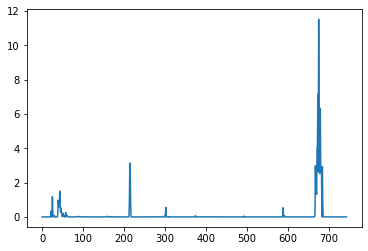

In [5]:
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)
plt.plot(df_forcing['APCP_surface'])

In [6]:
#Originial Version 
#Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
cfeAnalysis = []
cfeEnKF = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE

    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
    # Update usgs data and get value to put into EnKF
    usgs.update()
    obs = np.array(usgs.get_value('Flow')) #need array for EnKf function. should get this when initialize.  
    
    
    # print("1 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
    # print("1 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
    # print("1 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
    # print("1 runoff: open", cfe_open._values["DIRECT_RUNOFF"])
    # print("1 runoff: peturbed", cfe_peturbed._values["DIRECT_RUNOFF"])
    # print("1 runoff: analysis", cfe_analysis._values["DIRECT_RUNOFF"])
    # print("\n")
    
    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()
    
#     print("2 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
#     print("2 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
#     print("2 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
#     print("2 runoff: open", cfe_open._values["DIRECT_RUNOFF"])
#     print("2 runoff: peturbed", cfe_peturbed._values["DIRECT_RUNOFF"])
#     print("2 runoff: analysis", cfe_analysis._values["DIRECT_RUNOFF"])
    
#     print("\n")
    
    # Get state variables originial values from CFE Analysis to update in enkf
    # Get state vars from Peturbed. These are values as enkf uses
    soil_storage_avail = cfe_peturbed.get_value('soil_storage_avail_m')
    soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_m')
    surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')
    # if surface_runoff>0:
    #     print("surface_runoff",surface_runoff)
    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_depth')
    cfeOpen.append(outflow) #for plotting
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb_mean) #for plotting
    
    # Set EnKF value to usgs, mean, and covariance. Get value from it then
    enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
    enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf
    
#     print("3 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
#     print("3 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
#     print("3 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
#     print("3 runoff: open", cfe_open._values["land_surface_water__runoff_depth"])
#     print("3 runoff: peturbed", cfe_peturbed._values["land_surface_water__runoff_depth"])
#     print("3 runoff: analysis", cfe_analysis._values["land_surface_water__runoff_depth"])
#     print("\n")
    
    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([obs[i]]))
    enkf.update()
    
    # print("4 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
    # print("4 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
    # print("4 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
    # print("4 runoff: open", cfe_open._values["DIRECT_RUNOFF"])
    # print("4 runoff: peturbed", cfe_peturbed._values["DIRECT_RUNOFF"])
    # print("4 runoff: analysis", cfe_analysis._values["DIRECT_RUNOFF"])
    # print("\n")
    
    #For plotting############################# after this
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)
    
    state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
    state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_m')
    # state_transition_runoff       = enkf.get_value('surface_runoff_depth_updated_m')
    state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')
    
    #print("State Trans Runoff", state_transition_runoff)
    #print("CFE Open", outflow)
    #print("EnKF", outflow_enkf)
    
    print("5 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
    print("5 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
    print("5 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
    print("5 runoff: open", cfe_open._values["DIRECT_RUNOFF"])
    print("5 runoff: peturbed", cfe_peturbed._values["DIRECT_RUNOFF"])
    print("5 runoff: analysis", cfe_analysis._values["DIRECT_RUNOFF"])
    print("5 flow: open", cfe_open._values["land_surface_water__runoff_depth"])
    print("5 flow: peturbed", cfe_peturbed._values["land_surface_water__runoff_depth"])
    print("5 flow: analysis", cfe_analysis._values["land_surface_water__runoff_depth"])
    
    print("\n")
    
#     # Set value for CFE analysis based on the state variable change from the EnKF factor tog et true streamflow
    cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage) #look up value from lookup table based on EnKF factor   
    cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res) #look up value from lookup table based on EnKF factor   
    # cfe_analysis.set_value('DIRECT_RUNOFF', state_transition_runoff) 
    cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
    
    cfe_analysis.update() #get new streamflow value based on state var change
    
    outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
    cfeAnalysis.append(outflow_analysis) #for plotting
        
     # Update final model from value of analysis
    cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
    cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
    cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')
    #surface_runoff_depth_m replaced with DIRECT_RUNOFF
    cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
    cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
    cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)
    # cfe_peturbed.update()
  
    print("6 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
    print("6 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
    print("6 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
    print("6 runoff: open", cfe_open._values["DIRECT_RUNOFF"])
    print("6 runoff: peturbed", cfe_peturbed._values["DIRECT_RUNOFF"])
    print("6 runoff: analysis", cfe_analysis._values["DIRECT_RUNOFF"])
    print("6 flow: open", cfe_open._values["land_surface_water__runoff_depth"])
    print("6 flow: peturbed", cfe_peturbed._values["land_surface_water__runoff_depth"])
    print("6 flow: analysis", cfe_analysis._values["land_surface_water__runoff_depth"])
    print("\n")

    
#     if i > 100:
        
#         break
    
# # Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
# # want to see runoff q adjusted. vol adjusted in GIUH 
usgs.finalize()
enkf.finalize()

state_var_change_runoff 1
state_var_change_runoff 1
state_var_change_runoff 1
peturbed flow 0.014465502346721011
under estimaiton ratio [794.16338383]
under estimaiton [7.61000181]
CFE [0.01569572]
enkf [12.46496946]
5 soil moisture: open 0.0
5 soil moisture: peturbed 0.0
5 soil moisture: analysis 0
5 runoff: open 0.0
5 runoff: peturbed 0.0
5 runoff: analysis 0
5 flow: open 0.014465502346721011
5 flow: peturbed 0.014465502346721011
5 flow: analysis 0


state_var_change_runoff [794.16338383]
state_var_change_runoff [794.16338383]
state_var_change_runoff [794.16338383]
peturbed flow 0.014465502346721011
6 soil moisture: open 0.0
6 soil moisture: peturbed 0.0
6 soil moisture: analysis 0.0
6 runoff: open 0.0
6 runoff: peturbed 0.0
6 runoff: analysis 0.0
6 flow: open 0.014465502346721011
6 flow: peturbed 0.014465502346721011
6 flow: analysis 0.014465502346721011


state_var_change_runoff [794.16338383]
state_var_change_runoff [794.16338383]
state_var_change_runoff [794.16338383]
peturbed fl

In [7]:
# # Trying new version
# # Make empty matrices for plotting
# cfeOpen = []
# cfePeturbed = []
# cfeAnalysis = []
# cfeEnKF = []

# ## Loop through time. Set values for each model and get values
# for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE

#     # Set values for each model
#     cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
#     cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
#     #cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
#     # Update usgs data and get value to put into EnKF
#     usgs.update()
#     obs = np.array(usgs.get_value('Flow'))*50 #need array for EnKf function. should get this when initialize.  
    
#     # print("1 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
#     # print("1 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
#     # print("1 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
#     # print("1 runoff: open", cfe_open._values["DIRECT_RUNOFF"])
#     # print("1 runoff: peturbed", cfe_peturbed._values["DIRECT_RUNOFF"])
#     # print("1 runoff: analysis", cfe_analysis._values["DIRECT_RUNOFF"])
#     # print("\n")
    
#     # Update CFE open and peturbed. Get value for peturbed stats. 
#     cfe_open.update()
#     # cfe_peturbed.update()
    
# #     print("2 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
# #     print("2 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
# #     print("2 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
# #     print("2 runoff: open", cfe_open._values["DIRECT_RUNOFF"])
# #     print("2 runoff: peturbed", cfe_peturbed._values["DIRECT_RUNOFF"])
# #     print("2 runoff: analysis", cfe_analysis._values["DIRECT_RUNOFF"])  
# #     print("\n")
    
#     # Get state variables originial values from CFE Analysis to update in enkf
#     # Get state vars from Peturbed. These are values as enkf uses
#     soil_storage_avail = cfe_peturbed.get_value('soil_storage_avail_m')
#     soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_m')
#     surface_runoff = cfe_peturbed.get_value('DIRECT_RUNOFF')
#     # if surface_runoff>0:
#     #     print("surface_runoff",surface_runoff)
#     # Get values for plotting
#     outflow = cfe_open.get_value('land_surface_water__runoff_depth')
#     cfeOpen.append(outflow) #for plotting
#     outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
#     # Get mean and covariance for stats of ensemble runs for EnKF
#     outflow_peturb_mean = np.mean(outflow_peturb)
#     outflow_peturb_covar = np.cov(outflow_peturb)
#     cfePeturbed.append(outflow_peturb_mean) #for plotting
    
#     # Set EnKF value to usgs, mean, and covariance. Get value from it then
#     enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
#     enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
#     enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf
    
# #     print("3 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
# #     print("3 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
# #     print("3 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
# #     print("3 runoff: open", cfe_open._values["land_surface_water__runoff_depth"])
# #     print("3 runoff: peturbed", cfe_peturbed._values["land_surface_water__runoff_depth"])
# #     print("3 runoff: analysis", cfe_analysis._values["land_surface_water__runoff_depth"])
# #     print("\n")
    
#     enkf.set_value('x', np.array([outflow_peturb_mean]))
#     enkf.set_value('P', np.array([outflow_peturb_covar]))
#     enkf.set_value('z', np.array([obs[i]]))
#     enkf.update()
    
#     # print("4 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
#     # print("4 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
#     # print("4 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
#     # print("4 runoff: open", cfe_open._values["DIRECT_RUNOFF"])
#     # print("4 runoff: peturbed", cfe_peturbed._values["DIRECT_RUNOFF"])
#     # print("4 runoff: analysis", cfe_analysis._values["DIRECT_RUNOFF"])
#     # print("\n")
    
#     #For plotting############################# after this
#     outflow_enkf = enkf.get_value('enkf')
#     cfeEnKF.append(outflow_enkf)
    
#     ## Get EnKF values to set next
#     state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
#     state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_m')
#     # state_transition_runoff       = enkf.get_value('surface_runoff_depth_updated_m')
#     state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')
    
#     ## Set values based on new EnKF of CFE Peturbed and Analysis
#     #cfe_peturbed.set_value('soil_storage_avail_m', state_transition_soil_storage)
#     #cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res)
#     cfe_peturbed.set_value('state_var_change_runoff', state_transition_runoff_factor)
#     cfe_peturbed.update()
    
    
#     # print("5 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
#     # print("5 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
#     # print("5 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
#     # print("5 runoff: open", cfe_open._values["DIRECT_RUNOFF"])
#     # print("5 runoff: peturbed", cfe_peturbed._values["DIRECT_RUNOFF"])
#     # print("5 runoff: analysis", cfe_analysis._values["DIRECT_RUNOFF"])
#     print("5 flow: open", cfe_open._values["land_surface_water__runoff_depth"])
#     print("5 flow: peturbed", cfe_peturbed._values["land_surface_water__runoff_depth"])
#     # print("5 flow: analysis", cfe_analysis._values["land_surface_water__runoff_depth"])
#     print("\n")
    
#     # # Set value for CFE analysis based on the state variable change from the EnKF factor to get true streamflow
#     # cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage) #look up value from lookup table based on EnKF factor   
#     # cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res) #look up value from lookup table based on EnKF factor   
#     # # # cfe_analysis.set_value('DIRECT_RUNOFF', state_transition_runoff) 
#     # cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
#     # cfe_analysis.update()
#      #get new streamflow value based on state var change
    
#     #print("State Trans Runoff", state_transition_runoff)
#     #print("CFE Open", outflow)
#     #print("EnKF", outflow_enkf)
    
#     #outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
# #     outflow_analysis = cfe_analysis._values["land_surface_water__runoff_depth"]
# #     cfeAnalysis.append(outflow_analysis) #for plotting
   
        
#     # Update final model from value of analysis
#     # cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
#     # cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
#     # cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')
#     # #surface_runoff_depth_m replaced with DIRECT_RUNOFF
   
#     # print("6 soil moisture: open", cfe_open._values["soil_storage_avail_m"])
#     # print("6 soil moisture: peturbed", cfe_peturbed._values["soil_storage_avail_m"])
#     # print("6 soil moisture: analysis", cfe_analysis._values["soil_storage_avail_m"])
#     # print("6 runoff: open", cfe_open._values["DIRECT_RUNOFF"])
#     # print("6 runoff: peturbed", cfe_peturbed._values["DIRECT_RUNOFF"])
#     # print("6 runoff: analysis", cfe_analysis._values["DIRECT_RUNOFF"])
#     # print("6 flow: open", cfe_open._values["land_surface_water__runoff_depth"])
#     # print("6 flow: peturbed", cfe_peturbed._values["land_surface_water__runoff_depth"])
#     # print("6 flow: analysis", cfe_analysis._values["land_surface_water__runoff_depth"])
#     # print("\n")

    
# #     if i > 100:
        
# #         break
    
# # # Finalize models
# cfe_open.finalize(print_mass_balance=True)
# cfe_peturbed.finalize(print_mass_balance=True)
# # cfe_analysis.finalize(print_mass_balance=True)
# # # want to see runoff q adjusted. vol adjusted in GIUH 
# usgs.finalize()
# # enkf.finalize()

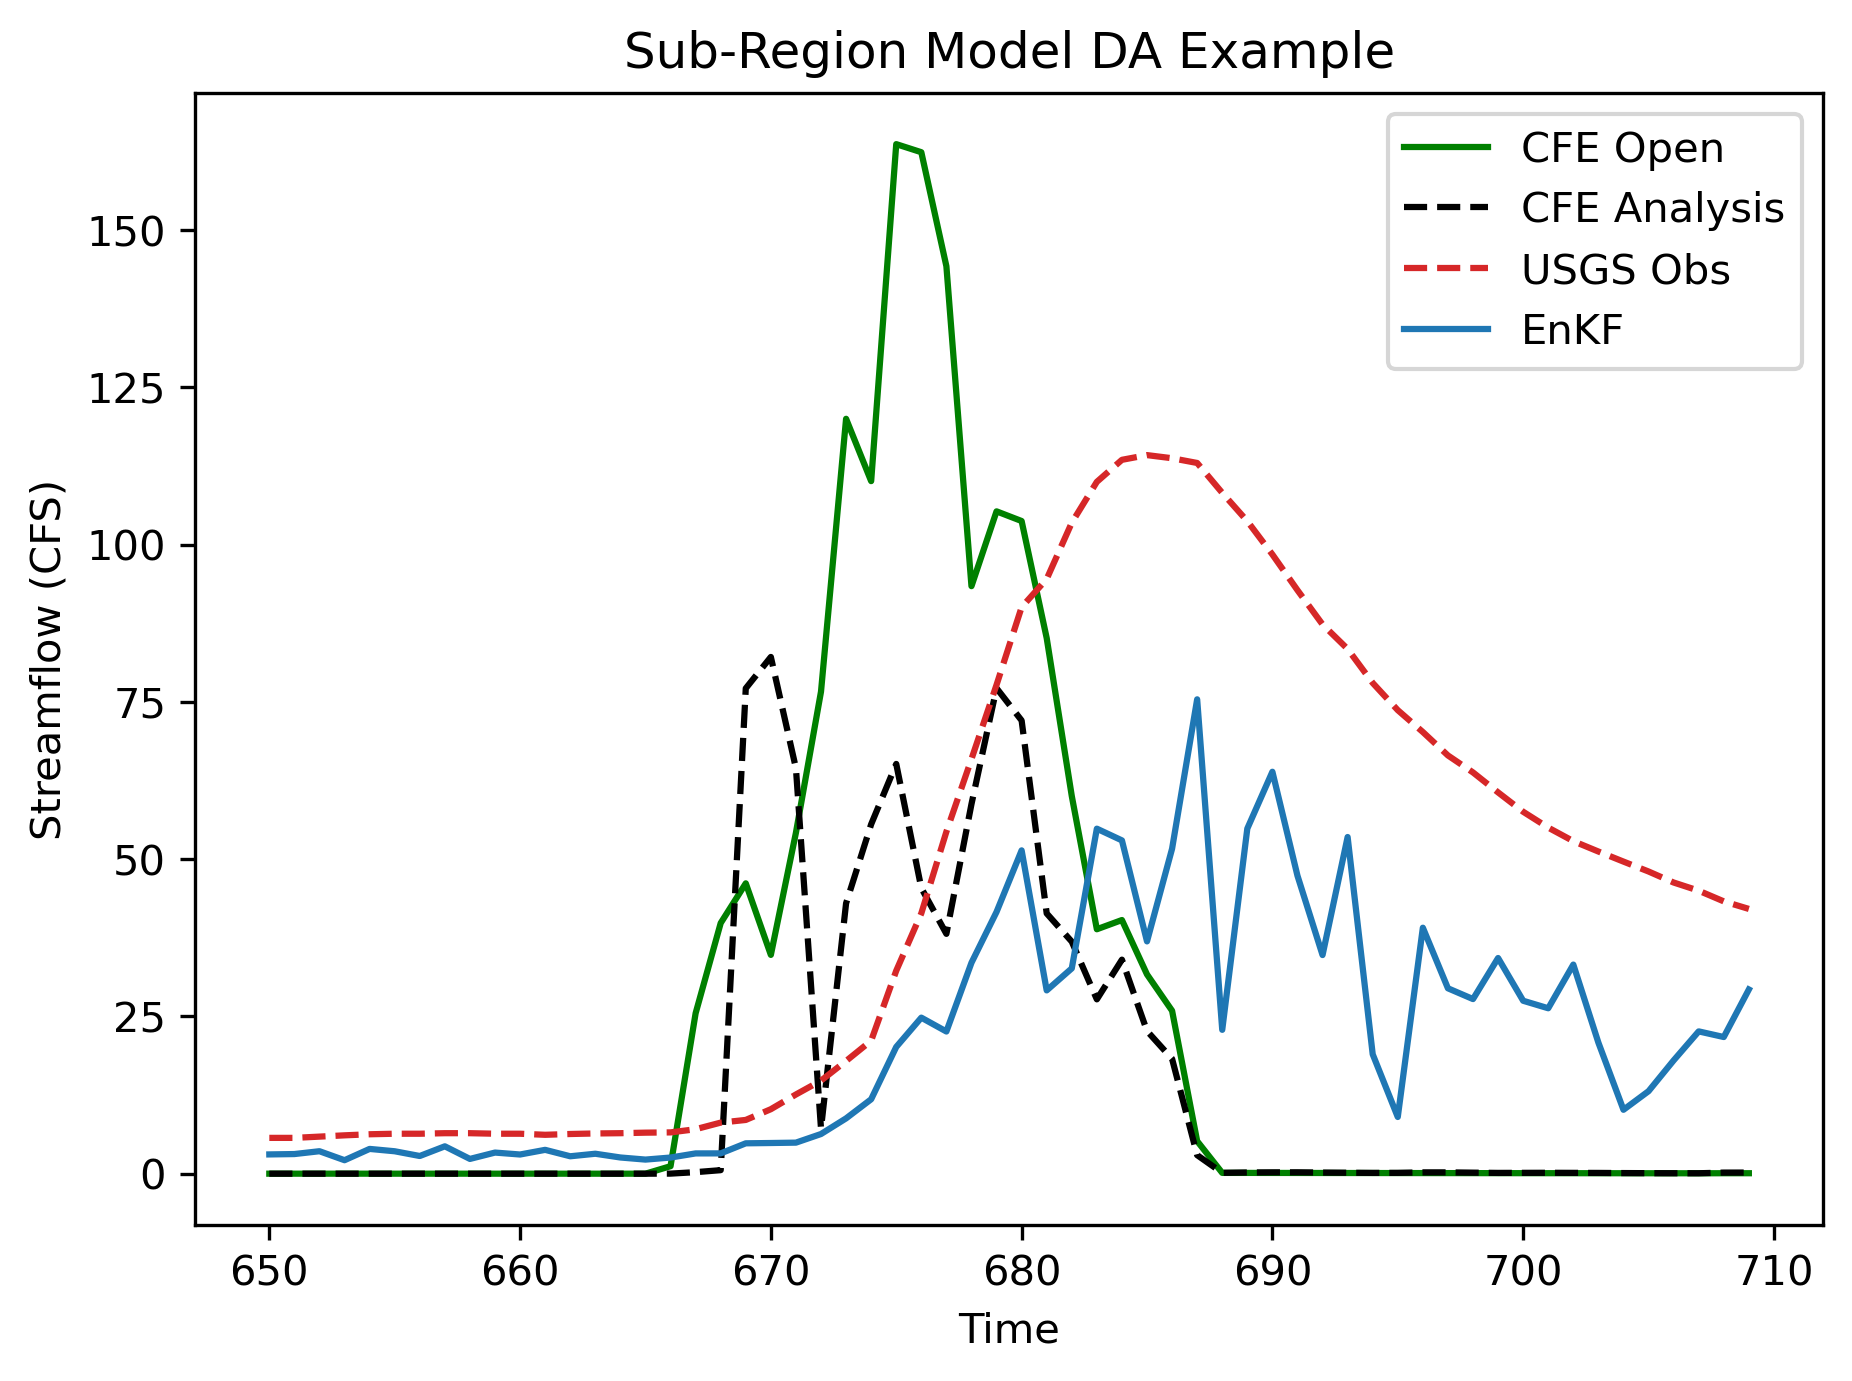

In [10]:
istart_plot=650
iend_plot=710
x = list(range(istart_plot, iend_plot))

fig = plt.figure(figsize = (7,5), dpi=300)

plt.title('Sub-Region Model DA Example')
# plt.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
plt.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
plt.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'black', linestyle='dashed', label = 'CFE Analysis')
plt.plot(x, obs[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed', label = 'USGS Obs')
plt.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')
plt.ylabel('Streamflow (CFS)')
plt.xlabel('Time')
plt.legend()


In [9]:
# cfe_open = bmi_cfe()
# cfe_perturbed = bmi_cfe()
# cfe_analysis = bmi_cfe()
# enkf = bmi_enkf()
# usgs = bmi_usgs()

# cfe_open.initialize(‘config_open.yml’)
# cfe_perturbed.initialize(‘config_perturbed.yml’)
# cfe_analysis.initialize(‘config_analysis.yml’)
# enkf.initialize(‘config_enkf_cfe_basinID.yml’)
# usgs.initialize(‘config_basinID.yml’)

# For time in daterange():
#     forcing = forcings[time]
#     cfe_open.set_value(forcing)
#     cfe_perturbed.set_value(forcing)
#     cfe_analysis.set_value(forcing)
#     usgs.update()
#     obs = usgs.get_value()

#     cfe_open.update()
#     cfe_perturbed.update()
#     mean, variance  = cfe_perturbed.get_value()

#     enkf.set_value(obs, mean, variance )

#     state_transition = enkf.get_value()

#     cfe_analysis.set_value(state_transition)
#     cfe_analysis.update()

#     cfe_perturbed.set_value(state_transition)
#     

#     cfe_updated_everything = cfe_analysis.get_value(everything)
#     cfe_perturbed.set_value(cfe_updated_everything)



# cfe_open.initialize(‘config_open.yml’)
# cfe_perturbed.initialize(‘config_perturbed.yml’)
# cfe_analysis.initialize(‘config_analysis.yml’)
# enkf.initialize(‘config_enkf_cfe_basinID.yml’)
# usgs.initialize(‘config_basinID.yml’)

